# Baseline Model

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Local Train / Test set paths

In [209]:
# Link to your sample train_path (manually selected for now)
local_train_path = '../raw_data/SAMPLES/TRAIN_10K'
local_test_path = '../raw_data/SAMPLES/TEST_10K'

## Cloud paths - TO DO

In [210]:
# Need to link to cloud storage account hosting all sample folders already ready to use by the model
cloud_train_path = '..'
cloud_test_path = '..'

## Preprocessing - Loading Train & Test images as Tensorflow generators

In [211]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [212]:
# ImageGenerator preprocess images / minimum params / to read .tif images
train_datagen = ImageDataGenerator(validation_split=0.2)
test_datagen = ImageDataGenerator()

In [213]:
# Load from directory to flow passsed into ImageGenerator
train_generator = train_datagen.flow_from_directory(local_train_path,
                                                    subset='training',
                                                    target_size=(96,96),
                                                    batch_size=16,
                                                    class_mode='binary')

val_generator = train_datagen.flow_from_directory(local_train_path,
                                                  subset='validation',
                                                  target_size=(96,96),
                                                  batch_size=16,
                                                  class_mode='binary')
                        

test_generator = test_datagen.flow_from_directory(local_test_path,
                                                  target_size=(96,96),
                                                  class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## Model

### Design and Init function

In [214]:
# INIT MODEL and COMPILE
from tensorflow.keras import layers, models
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

def init_model():
    model = models.Sequential()
    
    model.add(Rescaling(scale=1./255,input_shape=(96,96,3)))

    # Lets add convolution layers, 
    model.add(layers.Conv2D(8, kernel_size=2, activation='relu'))
  
    model.add(layers.Conv2D(16, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling2D(2))
    
    model.add(layers.Conv2D(16, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling2D(2))
    
    model.add(layers.Conv2D(32, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.Conv2D(32, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling2D(2))
    
    model.add(layers.Conv2D(16, kernel_size=2, activation="relu"))
    model.add(layers.MaxPooling2D(2))

    model.add(layers.Flatten())
    
    model.add(layers.Dense(40, activation='relu'))
  
    model.add(layers.Dense(1, activation='sigmoid'))

     ### Model compilation
    optim = Adam(learning_rate=0.0005)
    model.compile(loss='binary_crossentropy',
                  optimizer='Adam',
                  metrics=['accuracy'])
    return model

In [215]:
model = init_model()
model.summary()

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_64 (Rescaling)    (None, 96, 96, 3)         0         
                                                                 
 conv2d_226 (Conv2D)         (None, 95, 95, 8)         104       
                                                                 
 conv2d_227 (Conv2D)         (None, 94, 94, 16)        528       
                                                                 
 max_pooling2d_211 (MaxPooli  (None, 47, 47, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_228 (Conv2D)         (None, 46, 46, 16)        1040      
                                                                 
 max_pooling2d_212 (MaxPooli  (None, 23, 23, 16)       0         
 ng2D)                                               

### Model Training

In [216]:
from tensorflow.keras.callbacks import EarlyStopping

In [217]:
model = init_model()
epochs = 15
batch_size = 32
es = EarlyStopping(patience=3, restore_best_weights=True,verbose=1)

history = model.fit(train_generator,
                    epochs = epochs,
                    validation_data=val_generator,
                    batch_size = batch_size, 
                    verbose = 1, 
                    callbacks = [es])

Epoch 1/15
 33/500 [>.............................] - ETA: 1:09 - loss: 0.6940 - accuracy: 0.5227

KeyboardInterrupt: 

### Plot Loss & Accuracy charts FUNCTION

In [ ]:
# Plot loss history function
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(16,4))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0.3,0.8))
    ax[0].legend(['Train', 'Val'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='best')
    ax[1].set_ylim((0.5,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

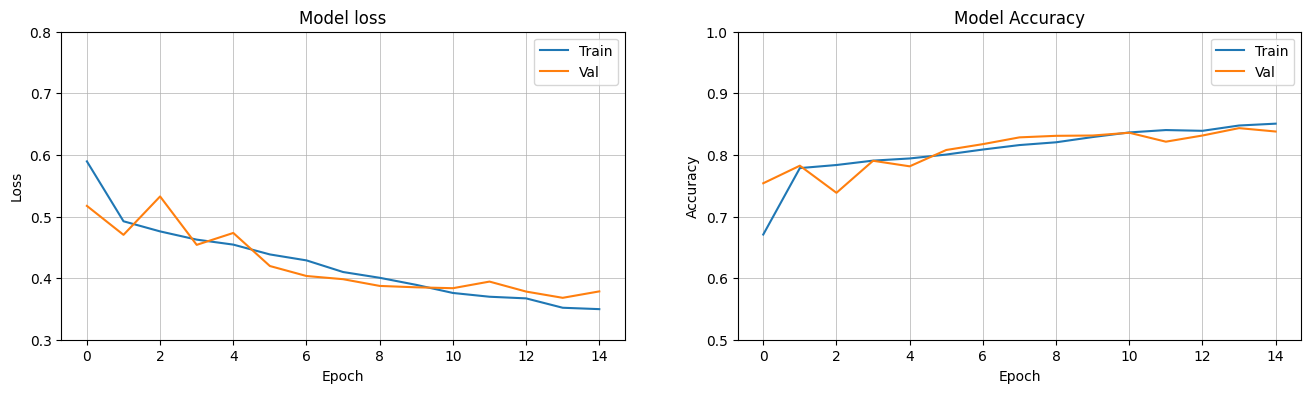

In [ ]:
# Plot the loss & accuracy curves
plot_loss_accuracy(history)

### Model Evaluation

In [207]:
results = model.evaluate(test_generator, verbose = 1 )
print(f'The accuracy on the test set is of {results[1]*100:.2f} %')

32/32 [==============================] - 3s 107ms/step - loss: 0.4310 - accuracy: 0.8020
The accuracy on the test set is of 80.20 %


In [25]:
from google.cloud import storage
from project_cancer_detection.ml_logic.params import PROJECT,BUCKET_NAME

# get default project id
# client = storage.Client()
# bucket = storage.Bucket(client, BUCKET_NAME, user_project=PROJECT)
# blobs = bucket.list_blobs()
# url = 'https://storage.googleapis.com/cancer-detection-small-datasets/test_1k/0/01132f290bf88852e10d23ea2f6f5557ba624f74.tif'
# blob = bucket.blob('/test_1k/0/01132f290bf88852e10d23ea2f6f5557ba624f74.tif')
# blob.download_to_filename('test.tif')


In [26]:
bucket = storage.Bucket(gs://cancer-detection-small-datasets)

SyntaxError: invalid syntax (4209936853.py, line 1)